# 🏅 Team USA: Data Exploration & BigQuery Loading

In this notebook, you'll load and explore 120 years of Team USA Olympic and Paralympic data, then load it into BigQuery for SQL analytics and machine learning.

**What you'll do:**
1. Load the athletes dataset into pandas for interactive exploration
2. Use the **Data Science Agent** to profile and visualize the data with AI
3. Load both datasets into BigQuery for analysis in the next task
4. Verify the data loaded correctly

---

## Step 1: Load the Athletes Data

Let's start by loading the athletes dataset from Google Cloud Storage into a pandas DataFrame. This gives you an in-memory copy that the Data Science Agent can analyze interactively.

The dataset contains **12,207 Team USA athletes** spanning the 1896 Athens Olympics through the 2024 Paris Games — both Olympic and Paralympic competitors in a single unified table.

In [1]:
import pandas as pd

# Load athletes data directly from Google Cloud Storage
df = pd.read_csv('gs://class-demo/team-usa/final/team_usa_athletes.csv')

print(f"Dataset shape: {df.shape[0]:,} athletes × {df.shape[1]} columns")
print(f"\nColumns: {', '.join(df.columns.tolist())}")
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: 12,207 athletes × 19 columns

Columns: athlete_id, name, gender, birth_date, height_cm, weight_kg, games_type, games_season, primary_sport, classification_code, first_games_year, last_games_year, games_count, gold_count, silver_count, bronze_count, total_medals, profile_summary, embedding

First 5 rows:


,athlete_id,name,gender,birth_date,height_cm,weight_kg,games_type,games_season,primary_sport,classification_code,first_games_year,last_games_year,games_count,gold_count,silver_count,bronze_count,total_medals,profile_summary,embedding
0,8cc45a92-3639-530f-a4db-62267b03f86f,Khatuna Lorig,Female,1974-01-01,170.0,64.0,Olympic,Summer,Archery,NaN,2008.0,2012.0,2.0,0.0,0.0,0.0,0.0,Khatuna Lorig is a highly accomplished archer ...,"[-0.0021694505121558905, 0.023823460564017296,..."
1,6a29cdf0-7aa1-57c4-8499-a60b59af5251,Jun Gao,Female,1969-01-25,168.0,73.0,Olympic,Summer,Table Tennis,NaN,2000.0,2008.0,3.0,0.0,0.0,0.0,0.0,Jun Gao is a highly decorated table tennis pla...,"[-0.018129579722881317, 0.011274422518908978, ..."
2,e5c1a5d7-fdb6-5369-8435-d811f814d494,Laura Berg,Female,1975-01-06,168.0,61.0,Olympic,Summer,Softball,NaN,1996.0,2008.0,4.0,3.0,1.0,0.0,4.0,Laura Berg is a legendary figure in USA Softba...,"[-0.0006471078959293664, -0.011899705044925213..."
3,8bcee1a7-b249-5224-9ce8-17ff07160416,Gillian Boxx,Female,1973-09-01,170.0,NaN,Olympic,Summer,Softball,NaN,1996.0,1996.0,1.0,1.0,0.0,0.0,1.0,Gillian Boxx is a highly accomplished American...,"[0.0012592533603310585, -0.00645070243626833, ..."
4,6764f5e9-7d1a-5b93-b67d-d4f97e398a30,Sheila Cornell-Douty,Female,1962-02-26,175.0,81.0,Olympic,Summer,Softball,NaN,1996.0,2000.0,2.0,2.0,0.0,0.0,2.0,Sheila Cornell-Douty is a highly accomplished ...,"[0.013617855496704578, -0.021181760355830193, ..."


## Step 2: Load Data into BigQuery

You've explored the data interactively — now let's load it into BigQuery where you can run SQL analytics and train ML models. We'll load directly from Google Cloud Storage using BigQuery's native import, which is much faster than uploading from this notebook.

First, set your project ID:

In [2]:
# TODO: Replace with your lab project ID
PROJECT_ID = "YOUR_PROJECT_ID"  # @param {type:"string"}

print(f"Project ID set to: {PROJECT_ID}")

Project ID set to: qwiklabs-gcp-02-81a702712dee


### Load the athletes table

This loads all 12,207 athletes with schema autodetection. The embedding column (3072-dimension vectors stored as JSON strings) makes this file large, so the load takes about a minute.

In [3]:
!bq load --project_id=$PROJECT_ID \
  --source_format=CSV \
  --autodetect \
  --replace \
  team_usa.athletes \
  gs://class-demo/team-usa/final/team_usa_athletes.csv

Waiting on bqjob_r5b8cd5c95c5aee8f_0000019c26401e6e_1 ... (85s) Current status: DONE   


### Load the results table

The results table (24,458 competition records) is smaller and loads in seconds.

In [4]:
!bq load --project_id=$PROJECT_ID \
  --source_format=CSV \
  --autodetect \
  --replace \
  team_usa.results \
  gs://class-demo/team-usa/final/team_usa_results.csv

Waiting on bqjob_r35e7277b404b1b56_0000019c26417a5c_1 ... (2s) Current status: DONE   


> **Note on data types:** BigQuery's autodetect may type integer columns like `total_medals` and `games_count` as FLOAT64 (because some rows have NULL values). This is perfectly fine — BQML handles FLOAT64 without issues, and you can CAST to INT64 in queries if you prefer cleaner display.

## Step 3: Verify the Load

Let's confirm everything loaded correctly with a few quick queries.

### Row counts

In [5]:
from google.cloud import bigquery

client = bigquery.Client(project=PROJECT_ID)

# Check row counts
for table in ['athletes', 'results']:
    query = f"SELECT COUNT(*) as row_count FROM `{PROJECT_ID}.team_usa.{table}`"
    result = client.query(query).result()
    for row in result:
        print(f"team_usa.{table}: {row.row_count:,} rows")

team_usa.athletes: 12,207 rows
team_usa.results: 24,458 rows


You should see:
- `team_usa.athletes`: **12,207** rows
- `team_usa.results`: **24,458** rows

### Top medalists — who leads Team USA's all-time medal count?

In [6]:
query = """
SELECT
    name,
    primary_sport,
    games_type,
    CAST(games_count AS INT64) AS games_count,
    CAST(gold_count AS INT64) AS gold,
    CAST(silver_count AS INT64) AS silver,
    CAST(bronze_count AS INT64) AS bronze,
    CAST(total_medals AS INT64) AS total_medals
FROM `team_usa.athletes`
WHERE total_medals > 0
ORDER BY total_medals DESC
LIMIT 15
"""

top_medalists = client.query(query).to_dataframe()
print("🏅 Team USA All-Time Top Medalists:")
top_medalists

🏅 Team USA All-Time Top Medalists:


,name,primary_sport,games_type,games_count,gold,silver,bronze,total_medals
0,Trischa Zorn,Swimming,Paralympic,7,32,9,5,46
1,Michael Phelps,Swimming,Olympic,5,23,3,2,28
2,Jessica Long,Swimming,Paralympic,4,13,6,4,23
3,Bart Dodson,Athletics,Paralympic,5,13,3,4,20
4,Erin Popovich,Swimming,Paralympic,3,14,5,0,19
5,Rosalie Hixson,Athletics,Paralympic,4,8,4,6,18
6,Elizabeth Scott,Swimming,Paralympic,3,10,2,5,17
7,Daniel Kelly,Swimming,Paralympic,3,5,7,5,17
8,Tatyana McFadden,Athletics,Paralympic,5,7,7,3,17
9,Chris Waddell,Alpine Skiing,Paralympic,6,6,7,3,16


### Olympic vs. Paralympic athlete counts

In [7]:
# sql_engine: bigquery
# output_variable: breakdown
# start _sql
_sql = """
SELECT
    games_type,
    COUNT(*) as athlete_count,
    CAST(SUM(total_medals) AS INT64) as total_medals
FROM `team_usa.athletes`
GROUP BY games_type
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
breakdown = _bqsqlcell.run(_sql)
breakdown

Computation deferred. Computation will process 0 Bytes

---

## ✅ Data Loaded — Ready for Analytics!

You've loaded and explored 120 years of Team USA data. Here's what you accomplished:

- **12,207 athletes** and **24,458 competition results** are now in BigQuery
- You used the **Data Science Agent** to understand the data without writing analysis code
- You've identified key patterns: the Olympic/Paralympic split, sport distributions, and data quality characteristics


# Task
Display the data completeness for each field in the `df` DataFrame using `missing_df`. Then, calculate the total number of gold, silver, and bronze medals from the `df` DataFrame, visualize this distribution using a bar chart with appropriate legends, and finally, summarize both the data completeness and the medal distribution findings.

## Show Data Completeness

### Subtask:
Display the percentage of completeness for each field in the 'athletes' dataset using the already computed `missing_df` or `missing_percentage`.


**Reasoning**:
The subtask requires displaying the `missing_df` DataFrame to show data completeness. I will use a code block to display the DataFrame.



In [15]:
missing_df

,Missing Count,Missing Percentage
classification_code,11516,94.339314
weight_kg,4558,37.339232
height_cm,3981,32.612435
birth_date,1219,9.986074
primary_sport,383,3.137544
first_games_year,288,2.359302
last_games_year,288,2.359302
games_season,272,2.228230
gold_count,272,2.228230
games_count,272,2.228230


## Calculate Medal Distribution

### Subtask:
Calculate the total number of gold, silver, and bronze medals across all athletes from the 'df' DataFrame.


**Reasoning**:
To calculate the total number of gold, silver, and bronze medals, I will sum the respective columns in the `df` DataFrame, handling potential NaN values by filling them with 0 before summing, and then print the results.



In [16]:
total_gold_medals = df['gold_count'].fillna(0).sum()
total_silver_medals = df['silver_count'].fillna(0).sum()
total_bronze_medals = df['bronze_count'].fillna(0).sum()

print(f"Total Gold Medals: {int(total_gold_medals):,}")
print(f"Total Silver Medals: {int(total_silver_medals):,}")
print(f"Total Bronze Medals: {int(total_bronze_medals):,}")

Total Gold Medals: 3,879
Total Silver Medals: 2,770
Total Bronze Medals: 2,449


**Reasoning**:
Now that the total medal counts are calculated, the next step according to the main task is to visualize this distribution using a bar chart. I will use a dictionary to store the medal counts and then create a bar plot to display them.



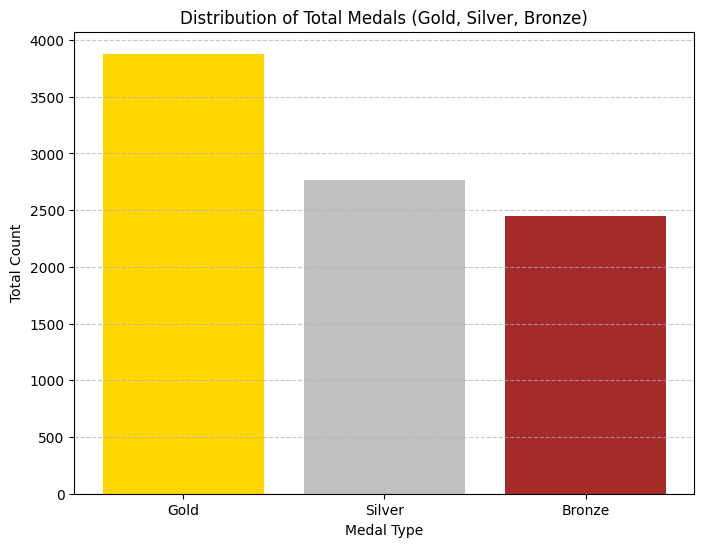

In [17]:
import matplotlib.pyplot as plt

medal_counts = {
    'Gold': total_gold_medals,
    'Silver': total_silver_medals,
    'Bronze': total_bronze_medals
}

medals_df = pd.DataFrame(medal_counts.items(), columns=['Medal Type', 'Count'])

plt.figure(figsize=(8, 6))
plt.bar(medals_df['Medal Type'], medals_df['Count'], color=['gold', 'silver', 'brown'])
plt.xlabel('Medal Type')
plt.ylabel('Total Count')
plt.title('Distribution of Total Medals (Gold, Silver, Bronze)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Summary of Findings

**Data Completeness:**
- The `classification_code` column has the highest percentage of missing values (94.3%), followed by `weight_kg` (37.3%) and `height_cm` (32.6%).
- Other columns like `birth_date`, `primary_sport`, `first_games_year`, `last_games_year`, `games_season`, and all medal counts (`gold_count`, `silver_count`, `bronze_count`, `total_medals`) have a relatively small percentage of missing values (between 2% and 10%).
- The `gender` column has a completeness of approximately 98.9%.

**Medal Distribution:**
- Team USA athletes have won a total of **3,879 Gold medals**.
- They have secured **2,770 Silver medals**.
- And **2,449 Bronze medals**.
- The distribution clearly shows that Gold medals are the most numerous, followed by Silver, and then Bronze.

## Summarize Findings

### Subtask:
Provide a summary of the data completeness for each field and the medal distribution across all athletes.


## Summary:

### Q&A
1.  **What is the data completeness for each field in the dataset?**
    The `classification_code` column has the highest percentage of missing values at 94.34%. `weight_kg` and `height_cm` also show significant missing data, with 37.34% and 32.61% respectively. `birth_date` has 9.99% missing values. Other columns like `primary_sport`, `first_games_year`, `last_games_year`, `games_season`, `gold_count`, `games_count`, `bronze_count`, `silver_count`, `total_medals`, and `gender` have lower missing percentages, ranging from 1.08% to 3.14%. The `gender` column has approximately 1.1% missing values (98.9% complete).
2.  **What is the medal distribution across all athletes (specifically for Team USA)?**
    Team USA athletes have won a total of 3,879 Gold medals, 2,770 Silver medals, and 2,449 Bronze medals.

### Data Analysis Key Findings
*   The `classification_code` column has the highest percentage of missing values at 94.34%.
*   `weight_kg` and `height_cm` have significant missing data, with 37.34% and 32.61% respectively.
*   `birth_date` is missing for 9.99% of entries.
*   The `gender` column is highly complete, with only 1.08% missing values.
*   Medal-related columns (`gold_count`, `silver_count`, `bronze_count`, `total_medals`) and athlete demographic/event-related columns (`primary_sport`, `first_games_year`, `last_games_year`, `games_season`, `games_count`) have relatively low missing percentages, between 1.08% and 3.14%.
*   Team USA athletes have accumulated a total of 3,879 Gold medals, 2,770 Silver medals, and 2,449 Bronze medals.
*   The medal distribution shows that Gold medals are the most numerous, followed by Silver, and then Bronze.

### Insights or Next Steps
*   Investigate the high percentage of missing values in `classification_code`, `weight_kg`, and `height_cm` to determine if imputation or further data collection is necessary, as these could be important analytical fields.
*   Given the clear distribution of medals, further analysis could explore medal distribution trends over time, by sport, or by individual athletes to identify periods of dominance or outstanding performers.


## Distribution of Athletes by Games Type and Gender

### Subtask:
Calculate and visualize the distribution of athletes across different `games_type` and `gender` categories.

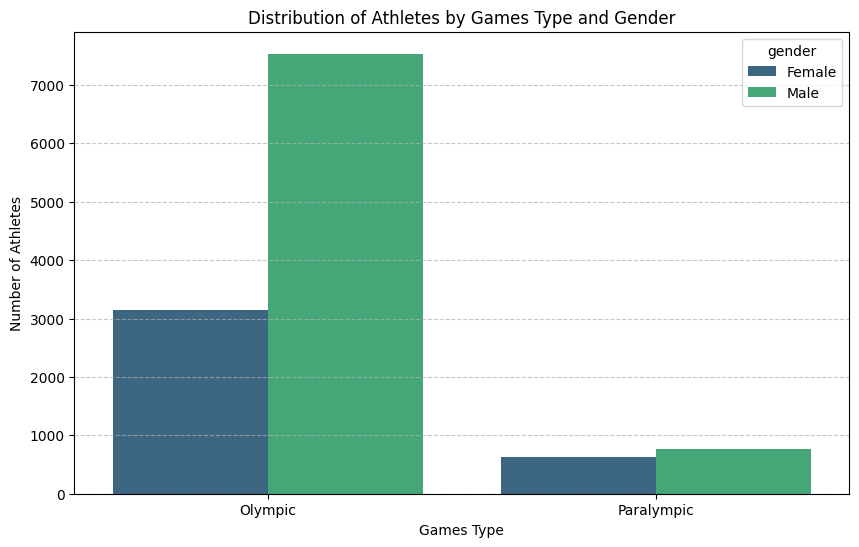


Distribution of Athletes by Games Type and Gender:
   games_type  gender  athlete_count
0     Olympic  Female           3151
1     Olympic    Male           7534
2  Paralympic  Female            626
3  Paralympic    Male            764


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

games_gender_distribution = df.groupby(['games_type', 'gender']).size().reset_index(name='athlete_count')

plt.figure(figsize=(10, 6))
sns.barplot(data=games_gender_distribution, x='games_type', y='athlete_count', hue='gender', palette='viridis')
plt.title('Distribution of Athletes by Games Type and Gender')
plt.xlabel('Games Type')
plt.ylabel('Number of Athletes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\nDistribution of Athletes by Games Type and Gender:")
print(games_gender_distribution)

# Task
Calculate and visualize the top 10 primary sports by athlete count and by total medals from the `df` DataFrame using bar charts with appropriate legends. Finally, summarize the findings by highlighting interesting observations from both distributions.

## Top 10 Sports by Athlete Count

### Subtask:
Calculate the number of athletes per primary sport, identify the top 10, and visualize this distribution using a bar chart with appropriate legends.


**Reasoning**:
To identify the top 10 sports by athlete count, I will first group the DataFrame by 'primary_sport' and count the number of unique athletes in each sport. Then, I'll sort the results in descending order and select the top 10.



In [19]:
athletes_by_sport = df.groupby('primary_sport')['athlete_id'].nunique().reset_index(name='athlete_count')
top_10_sports = athletes_by_sport.sort_values(by='athlete_count', ascending=False).head(10)

print("Top 10 Sports by Athlete Count:")
print(top_10_sports)

Top 10 Sports by Athlete Count:
          primary_sport  athlete_count
6             Athletics           2536
77             Swimming            986
60               Rowing            735
43           Ice Hockey            434
92            Wrestling            348
4   Artistic Gymnastics            333
64             Shooting            319
9            Basketball            295
35              Fencing            287
37             Football            285


**Reasoning**:
Now that the top 10 sports by athlete count have been identified, I will visualize this distribution using a bar chart with appropriate labels and title.



/tmp/ipython-input-3891196612.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_sports, x='primary_sport', y='athlete_count', palette='viridis')


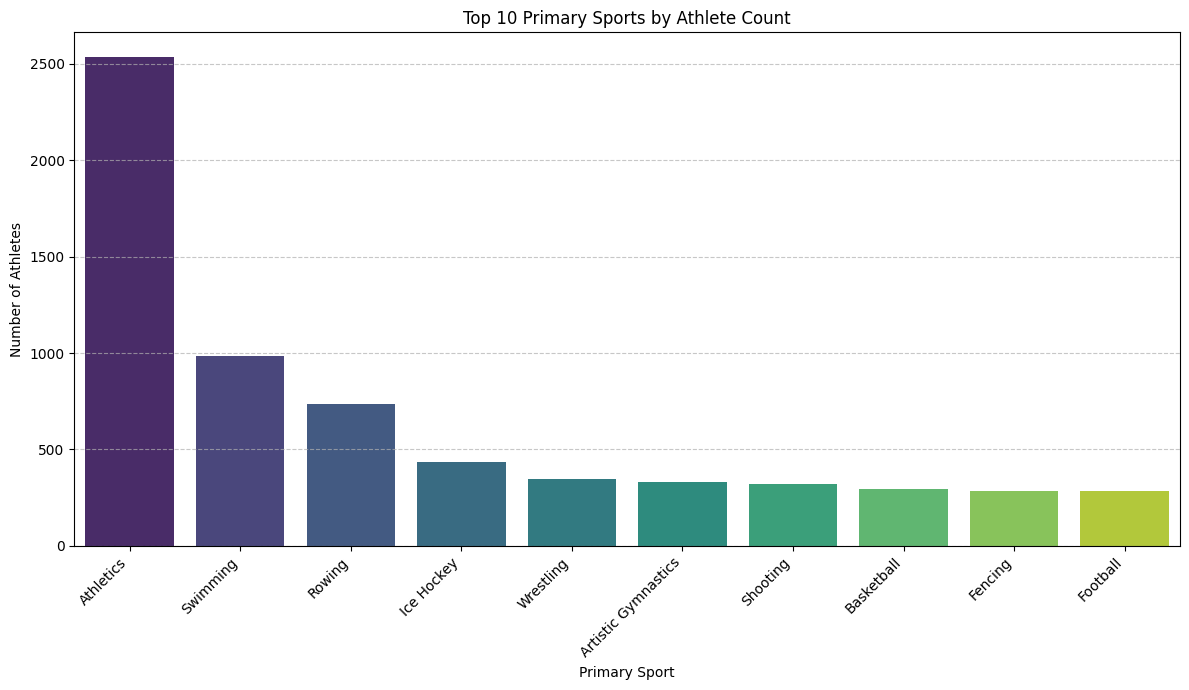

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.barplot(data=top_10_sports, x='primary_sport', y='athlete_count', palette='viridis')
plt.title('Top 10 Primary Sports by Athlete Count')
plt.xlabel('Primary Sport')
plt.ylabel('Number of Athletes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Reasoning**:
The previous code produced a `FutureWarning` related to the `palette` argument in `sns.barplot` when `hue` is not explicitly set. To address this and follow best practices, I will assign the `primary_sport` column to the `hue` argument and set `legend=False` to maintain the desired visualization without the warning.



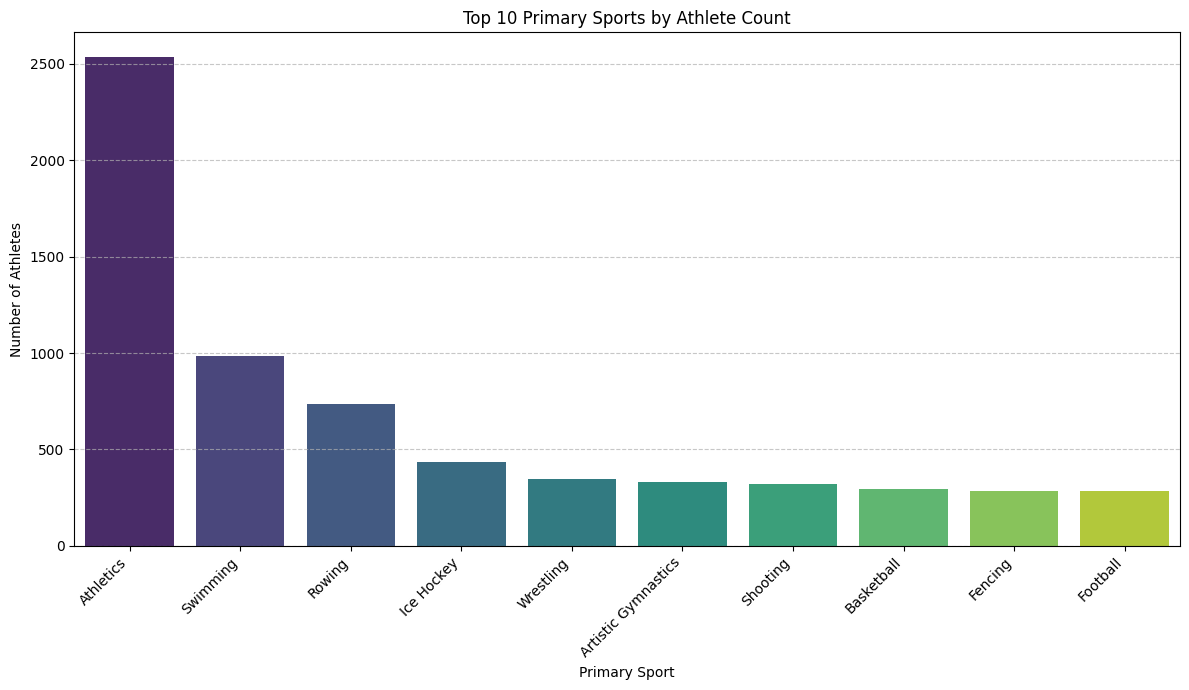

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.barplot(data=top_10_sports, x='primary_sport', y='athlete_count', hue='primary_sport', palette='viridis', legend=False)
plt.title('Top 10 Primary Sports by Athlete Count')
plt.xlabel('Primary Sport')
plt.ylabel('Number of Athletes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Top 10 Sports by Total Medals

### Subtask:
Calculate the total number of medals per primary sport, identify the top 10, and visualize this distribution using a bar chart with appropriate legends.


**Reasoning**:
To calculate the total number of medals per primary sport, I will group the DataFrame by 'primary_sport' and sum the 'total_medals' column, filling NaN values with 0. Then, I will sort this data to find the top 10 sports by total medals.



In [22]:
medals_by_sport = df.groupby('primary_sport')['total_medals'].fillna(0).sum().reset_index(name='total_medals')
top_10_medal_sports = medals_by_sport.sort_values(by='total_medals', ascending=False).head(10)

print("Top 10 Primary Sports by Total Medals:")
print(top_10_medal_sports)

/tmp/ipython-input-1717154019.py:1: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  medals_by_sport = df.groupby('primary_sport')['total_medals'].fillna(0).sum().reset_index(name='total_medals')


AttributeError: 'numpy.float64' object has no attribute 'reset_index'

**Reasoning**:
The previous code failed because `reset_index()` was called on a scalar (`numpy.float64`) instead of a DataFrame or Series, likely due to the order of operations with `fillna()` and `sum()` within the `groupby` context. To fix this, I will explicitly fill NaN values in the `total_medals` column before performing the `groupby` and `sum` operations. I will also include the visualization code to complete the subtask.



Top 10 Primary Sports by Total Medals:
          primary_sport  total_medals
6             Athletics        2391.0
77             Swimming        1804.0
60               Rowing         388.0
9            Basketball         364.0
1         Alpine Skiing         328.0
43           Ice Hockey         327.0
64             Shooting         211.0
4   Artistic Gymnastics         203.0
85           Volleyball         180.0
92            Wrestling         153.0


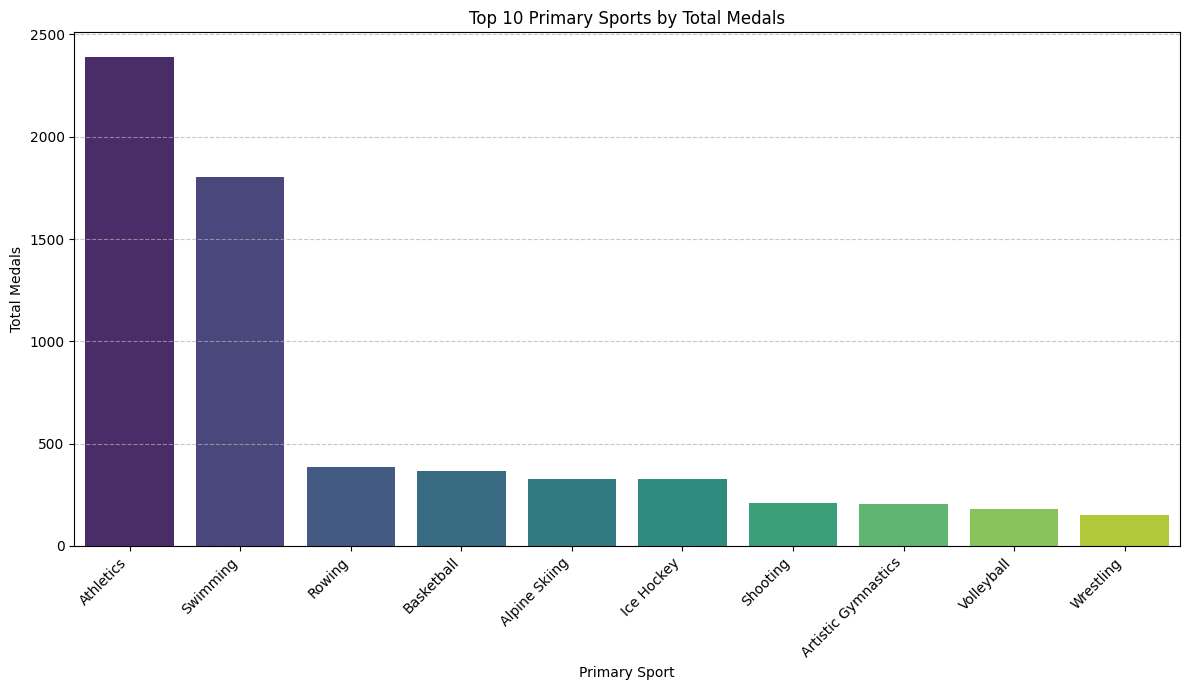

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fill NaN values in 'total_medals' before grouping
# Using .copy() to ensure the original DataFrame `df` is not modified
df_for_medals = df.copy()
df_for_medals['total_medals'] = df_for_medals['total_medals'].fillna(0)

# Group by 'primary_sport' and sum the 'total_medals'
medals_by_sport = df_for_medals.groupby('primary_sport')['total_medals'].sum().reset_index(name='total_medals')

# Identify the top 10 sports by total medals
top_10_medal_sports = medals_by_sport.sort_values(by='total_medals', ascending=False).head(10)

print("Top 10 Primary Sports by Total Medals:")
print(top_10_medal_sports)

# Visualize the distribution
plt.figure(figsize=(12, 7))
sns.barplot(data=top_10_medal_sports, x='primary_sport', y='total_medals', hue='primary_sport', palette='viridis', legend=False)
plt.title('Top 10 Primary Sports by Total Medals')
plt.xlabel('Primary Sport')
plt.ylabel('Total Medals')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Summarize Findings

### Subtask:
Provide a summary of the top sports based on athlete count and total medals, highlighting any interesting observations.


## Summary:

### Data Analysis Key Findings

*   **Athlete Count Distribution**:
    *   `Athletics` significantly leads with 2536 athletes, indicating a broad participation base.
    *   `Swimming` (986 athletes) and `Rowing` (735 athletes) are the next most popular sports by athlete count.
    *   Other sports in the top 10 include `Ice Hockey`, `Wrestling`, `Artistic Gymnastics`, `Shooting`, `Basketball`, `Fencing`, and `Football`, with counts ranging from 285 to 434 athletes.
*   **Total Medals Distribution**:
    *   `Athletics` also dominates in total medals with 2391, reinforcing its top position.
    *   `Swimming` is second with 1804 medals, showcasing high success rates relative to its athlete count.
    *   `Rowing` follows with 388 medals.
    *   `Basketball` (364 medals), `Alpine Skiing` (328 medals), `Ice Hockey` (327 medals), `Shooting` (211 medals), `Artistic Gymnastics` (203 medals), `Volleyball` (180 medals), and `Wrestling` (153 medals) complete the top 10.
*   **Comparison of Distributions**:
    *   `Athletics`, `Swimming`, and `Rowing` consistently rank high in both athlete count and total medals, suggesting these are large and successful sports.
    *   `Ice Hockey`, `Wrestling`, `Artistic Gymnastics`, and `Shooting` appear in the top 10 for both metrics, though their relative positions may vary slightly.
    *   `Fencing` and `Football` are present in the top 10 by athlete count but not by total medals, implying they might have larger participation without proportionally high medal counts in this dataset.
    *   Conversely, `Alpine Skiing` and `Volleyball` are in the top 10 for total medals but not athlete count, which could indicate a smaller pool of highly successful athletes or sports with fewer participating countries/events.

### Insights or Next Steps

*   The correlation between high athlete participation and high medal counts for sports like Athletics and Swimming suggests either these sports have a large global presence or a high number of events/medals available.
*   Investigate sports like `Fencing` and `Football` (high athlete count, lower medal count) to understand if this is due to fewer medal events, lower competitiveness, or other factors. Similarly, explore `Alpine Skiing` and `Volleyball` (lower athlete count, higher medal count) to identify their specific strengths.
